# Extended Kalman Filter

In [1]:
! pip install h5py
! pip install numpy-quaternion

Looking in indexes: http://192.168.16.2:8080/root/pypi/+simple/, https://pypi.ngc.nvidia.com
You should consider upgrading via the '/usr/bin/python -m pip install --upgrade pip' command.
Looking in indexes: http://192.168.16.2:8080/root/pypi/+simple/, https://pypi.ngc.nvidia.com
You should consider upgrading via the '/usr/bin/python -m pip install --upgrade pip' command.


In [2]:
from pathlib import Path
from scipy.spatial.transform import Rotation
import pandas as pd
import os
from os import path as osp
import numpy as np
from kalman_filter import ExtendedKalmanFilter
from metric import compute_ate_rte
import matplotlib.pyplot as plt
import h5py
import json
import quaternion
from data_utils import select_orientation_source

In [9]:
# Just need to pass in bias calibrated acc data, gyro data, gt position (with noise) and gt orientations (with noise) AS PD DATAFRAME

def test_kalman_filter(sample_data, gt_noise_std = 2, ori_noise_std = 0.05, std_dev = 0.01):

    time_arr = sample_data['time'].values
    
    quaternion = sample_data[['rotation.x', 'rotation.y', 'rotation.z', 'rotation.w',]].values

    # Create a rotation object from the quaternion
    rotation = Rotation.from_quat(quaternion)

    # Convert the quaternion to Euler angles
    euler_orientations = rotation.as_euler('xyz', degrees= False)

    # Convert acceleration into m/s^2
    acc = sample_data[['user_acc_x(m/s^2)', 'user_acc_y(m/s^2)', 'user_acc_z(m/s^2)']].values

    gyro = sample_data[['rotation_rate_x(radians/s)', 'rotation_rate_y(radians/s)', 'rotation_rate_z(radians/s)']].values

    N = len(sample_data)

    xy_obs_noise = np.random.normal(0.0, gt_noise_std, (N, 2))  # gen gaussian noise
    gt_trajectory_xy = sample_data[['translation.x','translation.y']].values
    obs_trajectory_xy = gt_trajectory_xy.copy()

    print(obs_trajectory_xy.shape)
    obs_trajectory_xy += xy_obs_noise  # add the noise to ground-truth positions
#     fig, ax = plt.subplots(1, 1, figsize=(12, 9))

#     xs, ys = gt_trajectory_xy[:, 0], gt_trajectory_xy[:, 1]
#     ax.plot(xs, ys, lw=2, label='ground-truth trajectory')

#     xs, ys = obs_trajectory_xy[:, 0], obs_trajectory_xy[:, 1]
#     ax.plot(xs, ys, lw=0, marker='.', markersize=2, alpha=0.4, label='noisy trajectory')

#     ax.set_xlabel('X [m]')
#     ax.set_ylabel('Y [m]')
#     ax.legend()
#     ax.grid()

    N = len(sample_data)

    orientation_obs_noise = np.random.normal(0.0, ori_noise_std, (N, 3))  # gen gaussian noise
    gt_orientation = euler_orientations
    obs_orientation = euler_orientations.copy()

    #obs_orientation += orientation_obs_noise  #We do not add the noise to orientation
#     fig, ax = plt.subplots(1, 1, figsize=(12, 9))

#     roll, pitch, yaw = gt_orientation[:, 0], gt_orientation[:, 1], gt_orientation[:,2]
#     ax.plot(roll, lw=2, label='ground-truth roll')
#     ax.plot(pitch, lw=2, label= 'ground truth pitch')
#     ax.plot(yaw, lw=2, label= 'ground truth yaw')

#     roll, pitch, yaw = obs_orientation[:, 0], obs_orientation[:, 1], obs_orientation[:,2]
#     ax.plot(roll, lw=0, marker='.', markersize=2, alpha=0.4, label='noisy roll')
#     ax.plot(pitch, lw=0, marker='.', markersize=2, alpha=0.4,label= 'noisy pitch')
#     ax.plot(yaw, lw=0, marker='.', markersize=2, alpha=0.4,label= 'noisy yaw')

#     ax.set_xlabel('X [m]')
#     ax.set_ylabel('Y [m]')
#     ax.legend()
#     ax.grid()

    # initial state x_0
    # State: [x position, y position, roll, pitch, yaw, velocity_x, velocity_y]; Assume velocity start at 0

    initial_list = [obs_trajectory_xy[0, 0], obs_trajectory_xy[0, 1], obs_orientation[0, 0], obs_orientation[0, 1], obs_orientation[0, 2], 0, 0]

    x = np.array(initial_list)

    # P covariance for initial state estimation error

    P = np.array([
        [gt_noise_std ** 2, 0, 0, 0, 0, 0, 0],
        [0, gt_noise_std ** 2, 0, 0, 0, 0, 0],
        [0, 0, ori_noise_std ** 2, 0, 0, 0, 0],
        [0, 0, 0,ori_noise_std ** 2 , 0, 0, 0],
        [0, 0, 0, 0, ori_noise_std ** 2, 0, 0],
        [0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0]
    ])

    # R (numpy.array): Measurement noise covariance matrix
    R = np.array([
        [gt_noise_std ** 2, 0, 0, 0, 0],
        [0, gt_noise_std ** 2, 0, 0, 0],
        [0, 0, ori_noise_std ** 2, 0, 0],
        [0, 0, 0,ori_noise_std ** 2 , 0],
        [0, 0, 0, 0, ori_noise_std ** 2]
    ])

    # State transition noise covariance will depend on how noisy is my acceleration and gyroscope data. For now lets assume a normal std of 0.01
    # Q (numpy.array): Process noise covariance matrix
    Q = np.eye(7) * (std_dev ** 2)

    # Initialize Kalman filter
    kf = ExtendedKalmanFilter(x, P)

    # Arrays to store estimated 2D pose [x, y, roll, pitch, yaw]
    mu_x = [x[0]]
    mu_y = [x[1]]
    mu_roll = [x[2]]
    mu_pitch = [x[3]]
    mu_yaw = [x[4]]

    # Arrays to store estimated error variance of 2D pose
    var_x = [P[0, 0]]
    var_y = [P[1, 1]]
    var_roll = [P[2, 2]]
    var_pitch = [P[3, 3]]
    var_yaw = [P[4, 4]]

    t_last = time_arr[0]

    for t_idx in range(1, N):
        t = time_arr[t_idx]
        dt = t - t_last
        
        # Get control input `u = [acceleration_x, acceleration_y, acceleration_z, roll_rate, pitch_rate, yaw_rate]`
        u = np.array([
            acc[t_idx, 0],
            acc[t_idx, 1],
            acc[t_idx, 2],
            gyro[t_idx, 0],
            gyro[t_idx, 1],
            gyro[t_idx, 2]
        ])
        
        # Because the acceleration and angular rates are already in the global frame,
        # we can directly use them in the propagation step
        
        # Propagate!
        kf.propagate(u, dt, Q)
        
        # Get measurement `z = [position_x, position_y, roll, pitch, yaw]`
        z = np.array([
            obs_trajectory_xy[t_idx, 0],
            obs_trajectory_xy[t_idx, 1],
            obs_orientation[t_idx, 0],
            obs_orientation[t_idx, 1],
            obs_orientation[t_idx, 2]
        ])
        
        # Update!
        kf.update(z, R)
        
        # Save estimated state to analyze later
        mu_x.append(kf.x[0])
        mu_y.append(kf.x[1])
        mu_roll.append(kf.x[2])
        mu_pitch.append(kf.x[3])
        mu_yaw.append(kf.x[4])
        
        # Save estimated variance to analyze later
        var_x.append(kf.P[0, 0])
        var_y.append(kf.P[1, 1])
        var_roll.append(kf.P[2, 2])
        var_pitch.append(kf.P[3, 3])
        var_yaw.append(kf.P[4, 4])
        
        t_last = t

    mu_x = np.array(mu_x)
    mu_y = np.array(mu_y)
    mu_roll = np.array(mu_roll)
    mu_pitch = np.array(mu_pitch)
    mu_yaw = np.array(mu_yaw)

    var_x = np.array(var_x)
    var_y = np.array(var_y)
    var_roll = np.array(var_roll)
    var_pitch = np.array(var_pitch)
    var_yaw = np.array(var_yaw)

    fig, ax = plt.subplots(1, 1, figsize=(12, 9))

    xs, ys = gt_trajectory_xy[:, 0], gt_trajectory_xy[:, 1]
    ax.plot(xs, ys, lw=2, label='ground-truth trajectory')

    xs, ys = obs_trajectory_xy[:, 0], obs_trajectory_xy[:, 1]
    ax.plot(xs, ys, lw=0, marker='.', markersize=0.5, alpha=0.4, label='noisy trajectory')

    ax.plot(mu_x, mu_y, lw=1, label='estimated trajectory', color='r')

    ax.set_xlabel('X [m]')
    ax.set_ylabel('Y [m]')
    ax.legend()
    ax.grid()

    pos_pred = np.zeros((N,2))
    pos_pred[:,0] = mu_x
    pos_pred[:,1] = mu_y


    ate, rte = compute_ate_rte(pos_pred, gt_trajectory_xy, 1)
    print('ATE: ', ate)
    print('RTE: ', rte)
    
    return ate, rte



In [10]:
dataset_folder = osp.join(Path(os.getcwd()).parents[2], 'localisation_datasets')
data_path = dataset_folder + '/Ronin_datasets/unseen_subjects_test_set/a006_2'

with open(osp.join(data_path, 'info.json')) as f:
    info = json.load(f)

info['ori_source'], ori, info['source_ori_error'] = select_orientation_source(data_path, max_ori_error=20.0, grv_only=True)
    
with h5py.File(osp.join(data_path, 'data.hdf5')) as f:
    gyro_uncalib = f['synced/gyro_uncalib']
    acce_uncalib = f['synced/linacce']
    gyro = gyro_uncalib - np.array(info['imu_init_gyro_bias'])
    acce = np.array(info['imu_acce_scale']) * (acce_uncalib - np.array(info['imu_acce_bias']))
    ts = np.copy(f['synced/time'])
    tango_pos = np.copy(f['pose/tango_pos'])
    
    # from tango frame to gt coord frame(?)
    init_tango_ori = quaternion.quaternion(*f['pose/tango_ori'][0])

# Compute the IMU orientation in the Tango coordinate frame.
ori_q = quaternion.from_float_array(ori) # ori is in global coord frame (?)

# rotation vector to get imu frame to tango frame
rot_imu_to_tango = quaternion.quaternion(*info['start_calibration'])

init_rotor = init_tango_ori * rot_imu_to_tango * ori_q[0].conj()

#we assume thais orientation is correct for now to rotate accelerations from the device coord frame to tango/global
# This is in w,x,y,z
ori_q = init_rotor * ori_q 

# convert ori from [w, x, y, z] to [x, y, z, w]
ori_q = quaternion.as_float_array(ori_q)
temp = ori_q[:, 1:].copy()
temp = np.concatenate((temp, ori_q[:,0].reshape(-1,1)),axis=1)
ori_q = temp.copy()

gt_pos = tango_pos

In [11]:
columns = ['rotation_rate_x(radians/s)', 'rotation_rate_y(radians/s)',
       'rotation_rate_z(radians/s)', 'user_acc_x(m/s^2)', 'user_acc_y(m/s^2)',
       'user_acc_z(m/s^2)', 'translation.x', 'translation.y', 'translation.z',
       'rotation.x', 'rotation.y', 'rotation.z', 'rotation.w', 'time']
data = pd.DataFrame(np.concatenate((gyro, acce, gt_pos, ori_q, ts.reshape(-1,1)), axis = 1))
data.columns = columns
display(data)

,rotation_rate_x(radians/s),rotation_rate_y(radians/s),rotation_rate_z(radians/s),user_acc_x(m/s^2),user_acc_y(m/s^2),user_acc_z(m/s^2),translation.x,translation.y,translation.z,rotation.x,rotation.y,rotation.z,rotation.w,time
0,-0.024128,0.019723,-0.007020,-0.109207,-0.195315,-0.026838,-0.143931,0.870489,0.085376,0.558919,-0.498252,-0.509894,-0.423514,3511.656733
1,-0.028089,0.023818,-0.006572,-0.140318,-0.184091,0.006607,-0.143917,0.870739,0.085313,0.559008,-0.498236,-0.509855,-0.423462,3511.661733
2,-0.030704,0.024543,-0.006410,-0.155476,-0.157402,0.028364,-0.143905,0.870992,0.085254,0.559092,-0.498216,-0.509832,-0.423402,3511.666733
3,-0.033043,0.026672,-0.004577,-0.147834,-0.160278,0.053157,-0.143892,0.871246,0.085198,0.559175,-0.498192,-0.509817,-0.423339,3511.671733
4,-0.035600,0.025956,-0.005188,-0.125891,-0.156516,0.055168,-0.143876,0.871487,0.085145,0.559257,-0.498165,-0.509806,-0.423274,3511.676733
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
173900,-0.055175,-0.033608,-0.004535,-0.077008,-0.060311,0.016555,0.993594,0.739009,-0.348831,0.582709,-0.444190,-0.544648,-0.408050,4381.156733
173901,-0.057651,-0.040320,-0.004897,-0.073918,-0.070983,-0.027333,0.993595,0.739010,-0.348832,0.582732,-0.444099,-0.544745,-0.407986,4381.161733
173902,-0.057668,-0.044062,-0.008103,-0.060086,-0.059773,-0.016335,0.993595,0.739010,-0.348832,0.582752,-0.443994,-0.544852,-0.407929,4381.166733
173903,-0.053418,-0.054270,-0.014820,-0.036691,-0.045819,-0.013950,0.993595,0.739011,-0.348832,0.582759,-0.443876,-0.544972,-0.407888,4381.171733


<Axes: >

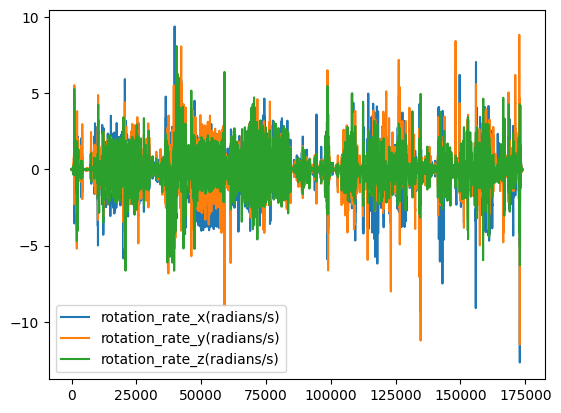

In [12]:
data[['rotation_rate_x(radians/s)', 'rotation_rate_y(radians/s)', 'rotation_rate_z(radians/s)']].plot()

In [13]:
data.describe()

,rotation_rate_x(radians/s),rotation_rate_y(radians/s),rotation_rate_z(radians/s),user_acc_x(m/s^2),user_acc_y(m/s^2),user_acc_z(m/s^2),translation.x,translation.y,translation.z,rotation.x,rotation.y,rotation.z,rotation.w,time
count,173905.000000,173905.000000,173905.000000,173905.000000,173905.000000,173905.000000,173905.000000,173905.000000,173905.000000,173905.000000,173905.000000,173905.000000,173905.000000,173905.000000
mean,0.004407,-0.003809,-0.006187,-0.021563,-0.255142,0.153350,0.324486,2.518172,-0.395339,-0.063412,-0.023492,-0.028447,-0.612623,3946.416733
std,0.900481,0.792881,0.841365,1.606526,1.340084,1.543373,6.144061,11.999002,0.449580,0.385756,0.478035,0.422905,0.251280,251.010968
min,-12.668112,-11.493737,-6.646051,-14.233211,-10.986192,-20.245884,-20.173844,-23.362355,-1.042187,-0.998704,-0.996738,-0.929857,-0.998692,3511.656733
25%,-0.228527,-0.231246,-0.268762,-0.486620,-0.566571,-0.326920,-0.081221,-1.445784,-0.939593,-0.311843,-0.452951,-0.347784,-0.785327,3729.036733
50%,0.004474,-0.004065,-0.003072,-0.047863,-0.139666,0.089434,0.134886,-1.251908,-0.301340,-0.120830,-0.092588,-0.103123,-0.642873,3946.416733
75%,0.282085,0.214025,0.221595,0.426881,0.180451,0.594474,1.624827,6.660367,-0.043362,0.147505,0.339180,0.273285,-0.476441,4163.796733
max,9.379716,8.835125,8.095541,46.979528,10.147523,25.780574,24.897344,33.131832,0.561733,0.998284,0.995789,0.996904,0.205369,4381.176733


(149000, 2)
ATE:  0.06059728245946154
RTE:  0.02105198015919326


(0.06059728245946154, 0.02105198015919326)

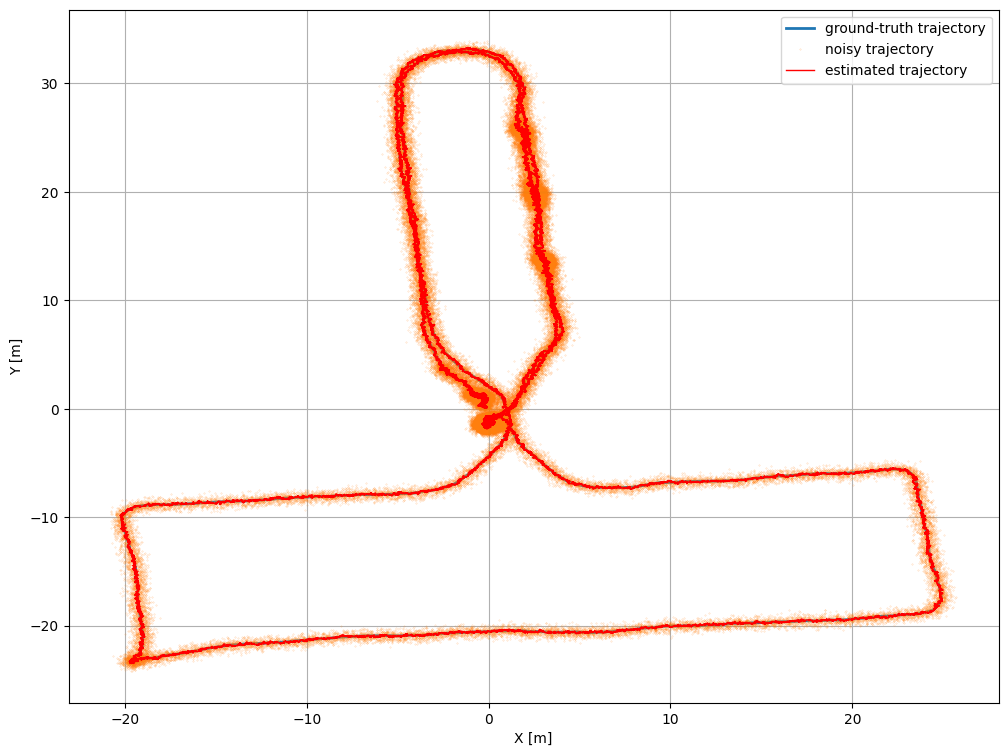

In [27]:
#best std_dev = 0.02
sample_data = data.iloc[1000:150000,:]
test_kalman_filter(sample_data, gt_noise_std=10, ori_noise_std=0.05, std_dev=0.02)

# ate_list = []
# std_dev_list = []

# for i in range(1,40, 1):
#     i = i/200
#     print('std_dev: ', i)
#     ate, rte = test_kalman_filter(sample_data, gt_noise_std = 10, ori_noise_std = 0.05, std_dev = i)
#     ate_list.append(ate)
#     std_dev_list.append(i)

# fig, ax = plt.subplots(1, 1, figsize=(12, 9))

# ax.plot(std_dev_list, ate_list, lw=2, label='ate')


# ax.set_xlabel('std_dev')
# ax.set_ylabel('ate')
# ax.legend()
# ax.grid()

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(12, 9))

ax.plot(std_dev_list, ate_list, lw=2, label='ate')


ax.set_xlabel('std_dev')
ax.set_ylabel('ate')
ax.legend()
ax.grid()